In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required libraries
!pip install tensorflow opencv-python numpy pandas scikit-learn matplotlib seaborn efficientnet

# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the RicketsPredictionModel class
class RicketsPredictionModel:
    def __init__(self, img_size=(224, 224)):
        self.img_size = img_size
        self.model = None
        self.history = None
        self.class_weights = None

    def check_dataset(self, data_dir):
        """Check if dataset is properly structured and images are readable"""
        print("Checking dataset structure...")
        dataset_stats = {'normal': [], 'rickets': []}
        issues_found = False

        for folder in ['normal', 'rickets']:
            folder_path = os.path.join(data_dir, folder)
            if not os.path.exists(folder_path):
                print(f"Error: {folder} folder not found at {folder_path}")
                issues_found = True
                continue

            print(f"\nChecking {folder} folder:")
            images = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
            print(f"Found {len(images)} PNG images")

            for img_name in images:
                img_path = os.path.join(folder_path, img_name)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
                    if img is None:
                        print(f"Warning: Could not read {img_name}")
                        issues_found = True
                        continue

                    dataset_stats[folder].append({
                        'name': img_name,
                        'shape': img.shape,
                        'has_alpha': img.shape[-1] == 4 if len(img.shape) > 2 else False
                    })
                except Exception as e:
                    print(f"Error processing {img_name}: {str(e)}")
                    issues_found = True

        # Print dataset statistics
        for folder, stats in dataset_stats.items():
            if stats:
                shapes = [s['shape'] for s in stats]
                alpha_channels = sum(1 for s in stats if s['has_alpha'])
                print(f"\n{folder.capitalize()} folder statistics:")
                print(f"Total images: {len(stats)}")
                print(f"Images with alpha channel: {alpha_channels}")
                print(f"Unique image shapes: {set(shapes)}")

        return not issues_found

    def create_model(self):
        """Create a model using transfer learning with EfficientNetB0"""
        base_model = applications.EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )
        base_model.trainable = False  # Freeze the base model

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.BatchNormalization(),
            layers.Dense(64, activation='relu', kernel_regularizer='l2'),
            layers.Dropout(0.5),
            layers.Dense(32, activation='relu', kernel_regularizer='l2'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )

        self.model = model
        return model

    def prepare_data(self, data_dir):
        """Prepare dataset with class balancing"""
        images = []
        labels = []
        class_counts = {'normal': 0, 'rickets': 0}

        # Process normal cases
        normal_dir = os.path.join(data_dir, 'normal')
        for img_name in os.listdir(normal_dir):
            if img_name.lower().endswith('.png'):
                img_path = os.path.join(normal_dir, img_name)
                try:
                    img = self.preprocess_image(img_path)
                    images.append(img)
                    labels.append(0)
                    class_counts['normal'] += 1
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")

        # Process rickets cases
        rickets_dir = os.path.join(data_dir, 'rickets')
        for img_name in os.listdir(rickets_dir):
            if img_name.lower().endswith('.png'):
                img_path = os.path.join(rickets_dir, img_name)
                try:
                    img = self.preprocess_image(img_path)
                    images.append(img)
                    labels.append(1)
                    class_counts['rickets'] += 1
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")

        # Calculate class weights
        total_samples = sum(class_counts.values())
        self.class_weights = {
            0: total_samples / (2 * class_counts['normal']),
            1: total_samples / (2 * class_counts['rickets'])
        }

        print("\nDataset summary:")
        print(f"Normal images: {class_counts['normal']}")
        print(f"Rickets images: {class_counts['rickets']}")
        print(f"Class weights: {self.class_weights}")

        return np.array(images), np.array(labels)

    def preprocess_image(self, image_path):
        """Preprocess a single image"""
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise ValueError(f"Could not read image at {image_path}")

        if len(img.shape) > 2 and img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        elif len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)

        # Apply CLAHE for better contrast
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab[..., 0] = clahe.apply(lab[..., 0])
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        # Normalize image
        img = img.astype(np.float32) / 255.0

        return img

    def get_callbacks(self, patience=20):
        """Setup training callbacks"""
        return [
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.keras',
                monitor='val_auc',
                mode='max',
                save_best_only=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                mode='min',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            )
        ]

    def train_model(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=4):
        """Train the model with data augmentation"""
        datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.2,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.7, 1.3],
            fill_mode='nearest'
        )

        print("\nStarting model training...")
        print(f"Training set shape: {X_train.shape}")
        print(f"Validation set shape: {X_val.shape}")

        # Fit the data generator on training data
        datagen.fit(X_train)

        # Generate more samples for small dataset
        steps_per_epoch = max(len(X_train) * 5 // batch_size, 30)

        self.history = self.model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=(X_val, y_val),
            steps_per_epoch=steps_per_epoch,
            callbacks=self.get_callbacks(),
            class_weight=self.class_weights,
            verbose=1
        )

    def predict_image(self, image_path):
        """Make prediction on a single image"""
        img = self.preprocess_image(image_path)
        img = np.expand_dims(img, axis=0)
        prediction = self.model.predict(img, verbose=0)[0][0]
        return prediction


# Initialize model
model = RicketsPredictionModel()

# Set your dataset path
data_dir = "/content/drive/MyDrive/rickets_dataset"

try:
    # Check dataset
    if not model.check_dataset(data_dir):
        print("Please fix dataset issues before proceeding.")
        raise ValueError("Dataset issues found")

    # Create model
    model.create_model()

    # Load and prepare data
    print("\nPreparing dataset...")
    images, labels = model.prepare_data(data_dir)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        images, labels,
        test_size=0.15,
        random_state=42,
        stratify=labels
    )

    # Train model
    model.train_model(X_train, y_train, X_val, y_val)

    # Save the model
    model_save_path = "/content/drive/MyDrive/rickets_model_final.keras"
    model.model.save(model_save_path)
    print(f"\nModel saved to {model_save_path}")

except Exception as e:
    print(f"\nAn error occurred: {str(e)}")


# Function to predict on an image from Google Drive
def predict_from_drive(image_filename):
    """Make prediction on an image from Google Drive"""
    try:
        # Construct full path
        image_path = f"/content/drive/MyDrive/rickets_dataset/{image_filename}"

        if not os.path.exists(image_path):
            print(f"Error: File not found at {image_path}")
            return

        # Load model
        model = RicketsPredictionModel()
        model.create_model()

        # Load weights
        model_path = "/content/drive/MyDrive/rickets_model_final.keras"
        print("Loading model weights...")
        model.model.load_weights(model_path)

        # Preprocess and predict
        print("Processing image and making prediction...")
        processed_img = model.preprocess_image(image_path)
        prediction = model.model.predict(
            np.expand_dims(processed_img, axis=0),
            verbose=0
        )[0][0]

        # Display results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Display image
        ax1.imshow(processed_img)
        ax1.set_title('Input Image')
        ax1.axis('off')

        # Display prediction
        probabilities = [1 - prediction, prediction]
        colors = ['green', 'red']
        bars = ax2.bar(['Normal', 'Rickets'], probabilities, color=colors)

        # Add percentage labels
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2., height,
                     f'{height * 100:.1f}%',
                     ha='center', va='bottom')

        ax2.set_title('Prediction Probability')
        ax2.set_ylabel('Probability')

        plt.tight_layout()
        plt.show()

        # Print results
        print("\nPrediction Results:")
        print(f"Probability of Rickets: {prediction * 100:.2f}%")
        print(f"Probability of Normal: {(1 - prediction) * 100:.2f}%")
        print(f"\nDiagnosis: {'Rickets' if prediction > 0.5 else 'Normal'}")

    except Exception as e:
        print(f"Error occurred: {str(e)}")


# Example: Predict on an image from Google Drive
#predict_from_drive('ricket5.png')  # Replace with your image filename


# For model evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

def plot_training_history(history):
    """Plot training history metrics"""
    metrics = ['loss', 'accuracy', 'auc']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label=f'Training {metric}')
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[idx].set_title(f'Model {metric}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric)
        axes[idx].legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.close()

def plot_roc_curve(y_true, y_pred_proba):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checking dataset structure...

Checking normal folder:
Found 6 PNG images

Checking rickets folder:
Found 10 PNG images

Normal folder statistics:
Total images: 6
Images with alpha channel: 6
Unique image shapes: {(660, 386, 4), (1548, 908, 4), (722, 410, 4), (1022, 822, 4), (808, 996, 4), (624, 402, 4)}

Rickets folder statistics:
Total images: 10
Images with alpha channel: 10
Unique image shapes: {(664, 452, 4), (642, 652, 4), (644, 652, 4), (812, 522, 4), (650, 632, 4), (652, 640, 4), (816, 994, 4), (644, 618, 4), (1550, 970, 4)}

Preparing dataset...

Dataset summary:
Normal images: 6
Rickets images: 10
Class weights: {0: 1.3333333333333333, 1: 0.8}

Starting model training...
Training set shape: (13, 224, 224, 3)
Validation set shape: (3, 224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
 4/30 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.3429 - auc: 0.3781 - loss: 2.4368

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_auc improved from -inf to 1.00000, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - accuracy: 0.5124 - auc: 0.5379 - loss: 2.3206 - val_accuracy: 0.3333 - val_auc: 1.0000 - val_loss: 2.3511 - learning_rate: 1.0000e-04
Epoch 2/100
 4/30 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.6018 - auc: 0.6420 - loss: 2.3053
Epoch 2: val_auc did not improve from 1.00000
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6136 - auc: 0.5731 - loss: 2.3446 - val_accuracy: 0.3333 - val_auc: 0.5000 - val_loss: 2.3444 - learning_rate: 1.0000e-04
Epoch 3/100
 4/30 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.7735 - auc: 0.3781 - loss: 2.2255
Epoch 3: val_auc did not improve from 1.00000
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5698 - auc: 0.6896 - loss: 2.3211 - val_accuracy: 0.3333 - val_auc: 0.5000 - val_loss: 2.3428 - learning_rate: 1.0000e-04
Epoch 4/100
 4/30 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - accuracy: 0.6018 - auc: 0.5375 - loss: 

In [ ]:
# Generate and save visualizations
plot_training_history(model.history)

# Make predictions on validation set
y_pred = model.model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate performance visualizations
plot_confusion_matrix(y_val, y_pred_classes)
plot_roc_curve(y_val, y_pred)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading model weights...
Processing image and making prediction...


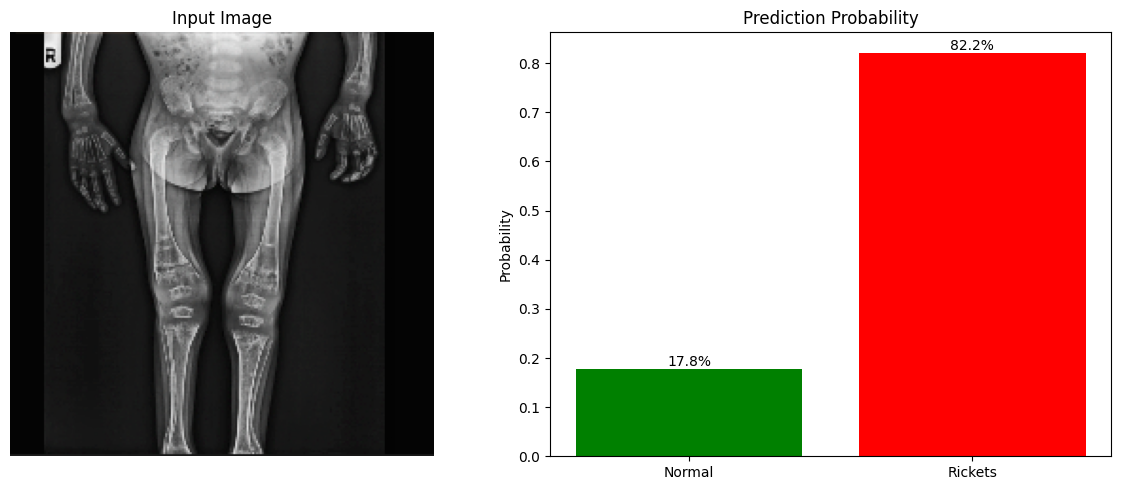


Prediction Results:
Probability of Rickets: 82.17%
Probability of Normal: 17.83%

Diagnosis: Rickets


In [ ]:
predict_from_drive('ricket8.png')